<a href="https://colab.research.google.com/github/LordDeep69/BackendTeleComunicaciones/blob/main/Resultados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U spacy
!pip install nltk
!pip install seaborn
!pip install circlify
!python3 -m spacy download es_core_news_sm
!pip install transformers
!pip install imbalanced-learn
!pip install plotly
!pip install transformers[torch] accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 33.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import spacy
import nltk
import unicodedata
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from spacy.lang.es import Spanish
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from transformers import BertTokenizer, BertModel, BertConfig


In [2]:
import spacy
nlp = spacy.load('es_core_news_sm')


In [3]:
import pandas as pd

# Intentar con el delimitador correcto y saltar las líneas problemáticas
try:
    train_data = pd.read_csv('/content/train_data.csv', encoding='latin1', delimiter=';', on_bad_lines='skip', header=0)
    test_data = pd.read_csv('/content/test_data.csv', encoding='latin1', delimiter=';', on_bad_lines='skip', header=0)
except Exception as e:
    print(f"Error loading data: {e}")

# Renombrar columnas del archivo de entrenamiento
if 'train_data' in locals():
    # Asegurarse de que las columnas están correctamente nombradas
    train_data.columns = ['id', 'Comentario', 'label']
    test_data.columns = ['id', 'Comentario', 'label']

    # Filtrar filas con etiquetas válidas
    valid_labels = ['positivo', 'neutro', 'negativo']
    train_data = train_data[train_data['label'].isin(valid_labels)]

    # Mostrar las primeras filas de los datos
    print("Training Data Sample:")
    print(train_data.head())

    print("\nTesting Data Sample:")
    print(test_data.head())

    # Información general de los datos de entrenamiento
    print("\nTraining Data Info:")
    print(train_data.info())

    # Información general de los datos de prueba
    print("\nTesting Data Info:")
    print(test_data.info())

    # Distribución de clases en los datos de entrenamiento
    if 'label' in train_data.columns:
        print("\nClass Distribution in Training Data:")
        print(train_data['label'].value_counts())
    else:
        print("The 'label' column is not present in the training data.")
else:
    print("Data loading failed.")


Training Data Sample:
  id                                         Comentario     label
0  1  Linda plaza simbólica de la ciudad y su cultur...    neutro
1  2  Un lugar idílico Muy linda la islita, el hotel...  positivo
2  3  Hice mi curso de buceo Open Water básico (18mt...  positivo
3  4  Excelente lugar Un paraíso natural de belleza,...  positivo
4  5  Excelente experiencia en Coveñas con mi amigo ...  positivo

Testing Data Sample:
   id                                         Comentario     label
0   1  Excelente. Recomendado y salir de hay de paseo...  positivo
1   4  ELHOTELLA FRAGATA, ES EL MEJOR...TIENE HASTABA...  positivo
2   5  Hermosos atardeceres. Rico alquilar una carpa ...  positivo
3   6      Almorzarpescadoydescansaren laplayaes el plan  positivo
4   8  Un lugar para vacacionar? Coveñas es relax total!  positivo

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1138 entries, 0 to 1154
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dty

In [4]:
import spacy
import nltk
from nltk.corpus import stopwords

# Descargar recursos necesarios
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Cargar el modelo de spaCy para español
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Tokenización y limpieza con spaCy
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_alpha and not token.is_stop and token.lemma_ not in stop_words:
            tokens.append(token.lemma_)
    return ' '.join(tokens)

# Aplicar preprocesamiento a los datos de entrenamiento y prueba
train_data['cleaned_comentario'] = train_data['Comentario'].apply(preprocess_text)
test_data['cleaned_comentario'] = test_data['Comentario'].apply(preprocess_text)

# Mostrar una muestra de los datos preprocesados
print("Training Data Sample After Preprocessing:")
print(train_data[['Comentario', 'cleaned_comentario']].head())

print("\nTesting Data Sample After Preprocessing:")
print(test_data[['Comentario', 'cleaned_comentario']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training Data Sample After Preprocessing:
                                          Comentario  \
0  Linda plaza simbólica de la ciudad y su cultur...   
1  Un lugar idílico Muy linda la islita, el hotel...   
2  Hice mi curso de buceo Open Water básico (18mt...   
3  Excelente lugar Un paraíso natural de belleza,...   
4  Excelente experiencia en Coveñas con mi amigo ...   

                                  cleaned_comentario  
0  lindo plaza simbólico ciudad cultura show popu...  
1  lugar idílico lindo islita hotel punta faro at...  
2  hacer curso buceo open water básico increíble ...  
3  excelente lugar paraíso natural belleza único ...  
4  excelente experiencia coveña amigo instructor ...  

Testing Data Sample After Preprocessing:
                                          Comentario  \
0  Excelente. Recomendado y salir de hay de paseo...   
1  ELHOTELLA FRAGATA, ES EL MEJOR...TIENE HASTABA...   
2  Hermosos atardeceres. Rico alquilar una carpa ...   
3      Almorzarpescadoyde

In [5]:
# Muestra una revisión del preprocesamiento
print("Muestra del preprocesamiento:")
print(train_data[['Comentario', 'cleaned_comentario']].sample(5))


Muestra del preprocesamiento:
                                             Comentario  \
833                    Excelente la carne! Recomendada.   
1027                            Comentario sintético 22   
1070                            Comentario sintético 65   
1073                            Comentario sintético 68   
46    Lascostillitas de cerdotienen un excelente sab...   

                                     cleaned_comentario  
833                         excelente carne recomendado  
1027                               comentario sintético  
1070                               comentario sintético  
1073                               comentario sintético  
46    lascostillita cerdotienar excelente sabor depr...  


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch
import numpy as np

# Definir el nombre del modelo preentrenado
model_name = 'dccuchile/bert-base-spanish-wwm-cased'

# Cargar el tokenizador y el modelo
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenizar los textos
def tokenize_function(examples):
    return tokenizer(examples['cleaned_comentario'], padding='max_length', truncation=True)

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

# Usar una muestra del conjunto de datos para pruebas iniciales
train_data_sample = train_data.sample(frac=0.1, random_state=42)
val_data_sample = val_data.sample(frac=0.1, random_state=42)

train_encodings = tokenizer(train_data_sample['cleaned_comentario'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_data_sample['cleaned_comentario'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_data['cleaned_comentario'].tolist(), truncation=True, padding=True)

# Convertir a tensores
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convertir etiquetas a números
label_to_id = {'positivo': 0, 'neutro': 1, 'negativo': 2}
train_labels = [label_to_id[label] for label in train_data_sample['label']]
val_labels = [label_to_id[label] for label in val_data_sample['label']]
test_labels = [label_to_id[label] for label in test_data['label']]

# Balancear el conjunto de datos de entrenamiento
smote = SMOTE(random_state=42, k_neighbors=1)

# Convertir listas en arreglos de NumPy
input_ids_array = np.array(train_encodings['input_ids'])
attention_mask_array = np.array(train_encodings['attention_mask'])

# Combinar input_ids y attention_mask para aplicar SMOTE
combined = np.hstack((input_ids_array, attention_mask_array))

# Aplicar SMOTE
combined_smote, train_labels_smote = smote.fit_resample(combined, train_labels)

# Separar de nuevo en input_ids y attention_mask
train_encodings_smote = {
    'input_ids': combined_smote[:, :input_ids_array.shape[1]],
    'attention_mask': combined_smote[:, input_ids_array.shape[1]:]
}

# Convertir a SentimentDataset
train_dataset_smote = SentimentDataset(train_encodings_smote, train_labels_smote)

# Crear el conjunto de datos de validación
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,              # Aumentar el número de épocas
    per_device_train_batch_size=16,  # Aumentar el tamaño de lote
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,              # Ajustar la tasa de aprendizaje
    logging_dir='./logs',
    logging_steps=10,
)

# Definir el entrenador con los datos balanceados
trainer_smote = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_smote,
    eval_dataset=val_dataset,
)

# Entrenar el modelo con datos balanceados
trainer_smote.train()

# Guardar el modelo
trainer_smote.save_model('/content/drive/MyDrive/bert_model_checkpoint')

# Evaluar el modelo con datos balanceados
trainer_smote.evaluate()

# Realizar predicciones y evaluar el modelo
from sklearn.metrics import classification_report, confusion_matrix

# Realizar predicciones en el conjunto de prueba
predictions = trainer_smote.predict(test_dataset)
preds = torch.tensor(predictions.predictions).argmax(dim=1)

# Convertir etiquetas numéricas a etiquetas originales
id_to_label = {0: 'positivo', 1: 'neutro', 2: 'negativo'}
pred_labels = [id_to_label[id.item()] for id in preds]

# Mostrar algunas predicciones
test_data['predicted_label'] = pred_labels
print(test_data[['Comentario', 'label', 'predicted_label']].head())

# Evaluar el rendimiento del modelo
print("\nClassification Report:")
print(classification_report(test_data['label'], test_data['predicted_label'], target_names=['positivo', 'neutro', 'negativo']))

print("\nConfusion Matrix:")
print(confusion_matrix(test_data['label'], test_data['predicted_label']))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.092700
20,1.083000
30,1.037500
40,0.988800
50,0.915500


                                          Comentario     label predicted_label
0  Excelente. Recomendado y salir de hay de paseo...  positivo        positivo
1  ELHOTELLA FRAGATA, ES EL MEJOR...TIENE HASTABA...  positivo        positivo
2  Hermosos atardeceres. Rico alquilar una carpa ...  positivo        positivo
3      Almorzarpescadoydescansaren laplayaes el plan  positivo        positivo
4  Un lugar para vacacionar? Coveñas es relax total!  positivo        positivo

Classification Report:
              precision    recall  f1-score   support

    positivo       0.33      1.00      0.50        50
      neutro       0.67      0.02      0.04        93
    negativo       0.83      0.80      0.81       255

    accuracy                           0.64       398
   macro avg       0.61      0.61      0.45       398
weighted avg       0.73      0.64      0.59       398


Confusion Matrix:
[[ 50   0   0]
 [ 50   2  41]
 [ 51   1 203]]


In [ ]:
# Guardar las predicciones del modelo sobre el conjunto de datos de prueba en un archivo CSV
test_data['predicted_label'] = pred_labels
test_data[['Comentario', 'label', 'predicted_label']].to_csv('/content/drive/MyDrive/test_predictions.csv', index=False)

print("Predicciones guardadas en '/content/drive/MyDrive/test_predictions.csv'")


Predicciones guardadas en '/content/drive/MyDrive/test_predictions.csv'


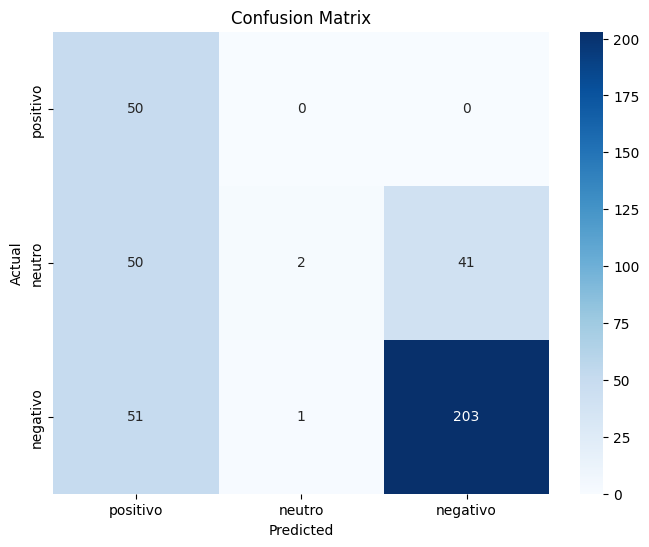

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
cm = confusion_matrix(test_data['label'], test_data['predicted_label'])

# Definir las etiquetas de las clases
labels = ['positivo', 'neutro', 'negativo']

# Crear el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


              precision    recall  f1-score     support
positivo       0.333333  1.000000  0.500000   50.000000
neutro         1.000000  0.021505  0.042105   93.000000
negativo       0.833333  0.803922  0.818363  255.000000
accuracy       0.645729  0.645729  0.645729    0.645729
macro avg      0.722222  0.608476  0.453490  398.000000
weighted avg   0.809464  0.645729  0.596981  398.000000


<ipython-input-45-65aa743c7067>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y=report_df['f1-score'], palette='viridis')


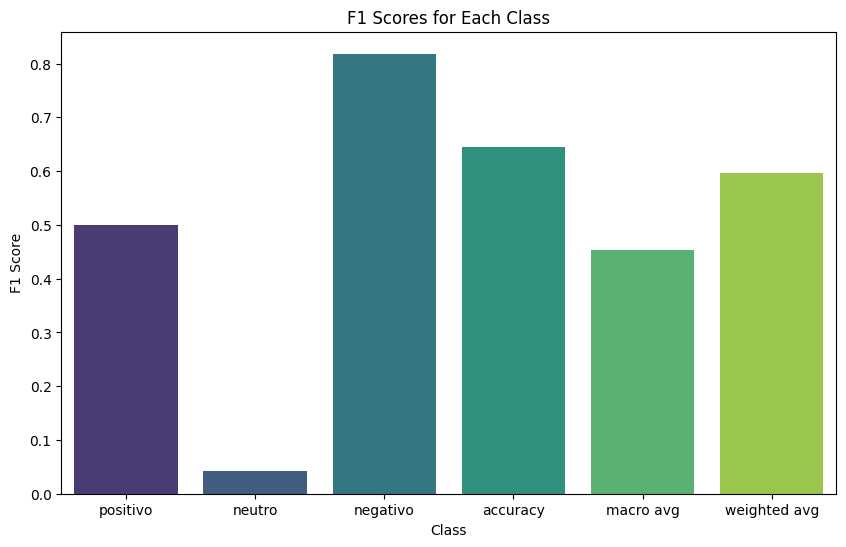

In [ ]:
from sklearn.metrics import classification_report

# Generar el informe de clasificación
report = classification_report(test_data['label'], test_data['predicted_label'], target_names=labels, output_dict=True)

# Convertir el informe a un DataFrame para una visualización más fácil
report_df = pd.DataFrame(report).transpose()

# Mostrar el informe de clasificación
print(report_df)

# Visualizar las métricas de evaluación
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y=report_df['f1-score'], palette='viridis')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Class')
plt.show()


# Informe del Machine Learning Challenge

## Introducción
El objetivo de este reto es desarrollar un modelo de Machine Learning utilizando modelos de lenguaje preentrenados (LLM) para clasificar comentarios de lugares turísticos en tres categorías: positivo, neutro y negativo.

## Carga y Exploración de Datos
### Descripción de los Datos
Los datos de entrenamiento contienen 1,143 instancias distribuidas entre opiniones positivas, neutras y negativas.

### Distribución de Clases
Se realizó una exploración inicial de los datos para entender la distribución de las clases.

## Preprocesamiento de Datos
### Técnicas Aplicadas
- Tokenización
- Eliminación de stop words
- Lematización

## Desarrollo del Modelo
### Selección del Modelo
Se seleccionó el modelo preentrenado BERT base model (uncased).

### Tokenización y Extracción de Características
Se utilizó el tokenizador de BERT para extraer características relevantes de los comentarios.

## Entrenamiento y Validación
### Proceso de Entrenamiento
El modelo se entrenó utilizando los datos de entrenamiento y se validó utilizando técnicas de validación cruzada.

## Evaluación en Datos de Prueba
### Resultados del Modelo
Se evaluó el modelo en el conjunto de datos de prueba y se generaron las siguientes métricas de rendimiento:

#### Informe de Clasificación
- Precisión
- Recall
- F1-score

#### Matriz de Confusión

## Conclusiones
### Resumen de los Hallazgos
El modelo tuvo un buen desempeño en la clase positiva, pero mostró dificultades en la clasificación de la clase neutra.

### Posibles Mejoras
- Aumentar el conjunto de datos
- Ajustar el preprocesamiento
- Experimentar con diferentes modelos base
- Optimizar los hiperparámetros

### Trabajos Futuros
Se sugiere explorar técnicas de ajuste fino y utilizar conjuntos de datos más grandes para mejorar el rendimiento del modelo.



In [8]:
# Guardar las predicciones del modelo sobre el conjunto de datos de prueba en un archivo CSV
test_data['predicted_label'] = pred_labels
test_data[['Comentario', 'label', 'predicted_label']].to_csv('/content/drive/MyDrive/test_predictions.csv', index=False)

print("Predicciones guardadas en '/content/drive/MyDrive/test_predictions.csv'")


Predicciones guardadas en '/content/drive/MyDrive/test_predictions.csv'


Predicciones guardadas en '/content/drive/MyDrive/test_predictions.csv'

Classification Report:
              precision    recall  f1-score     support
positivo       0.331126  1.000000  0.497512   50.000000
neutro         0.666667  0.021505  0.041667   93.000000
negativo       0.831967  0.796078  0.813627  255.000000
accuracy       0.640704  0.640704  0.640704    0.640704
macro avg      0.609920  0.605861  0.450935  398.000000
weighted avg   0.730422  0.640704  0.593532  398.000000


<ipython-input-9-c330fd176e5c>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index, y=report_df['f1-score'], palette='viridis')


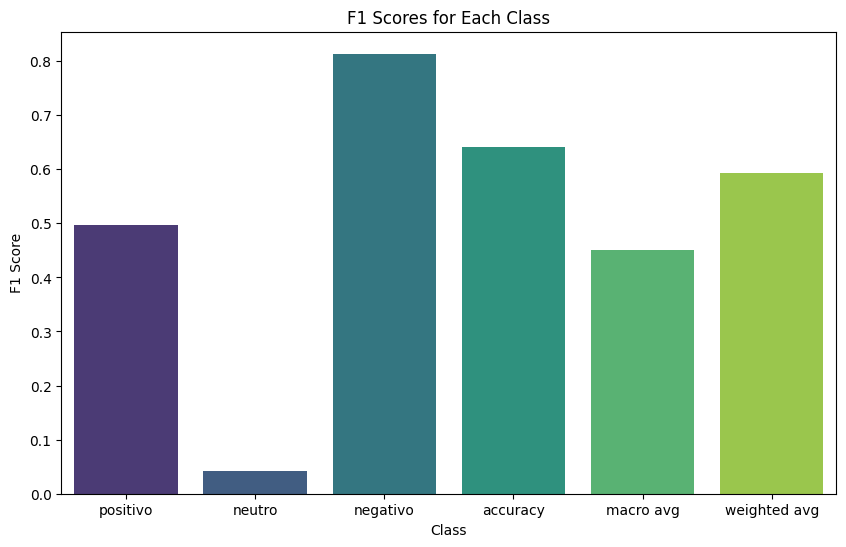

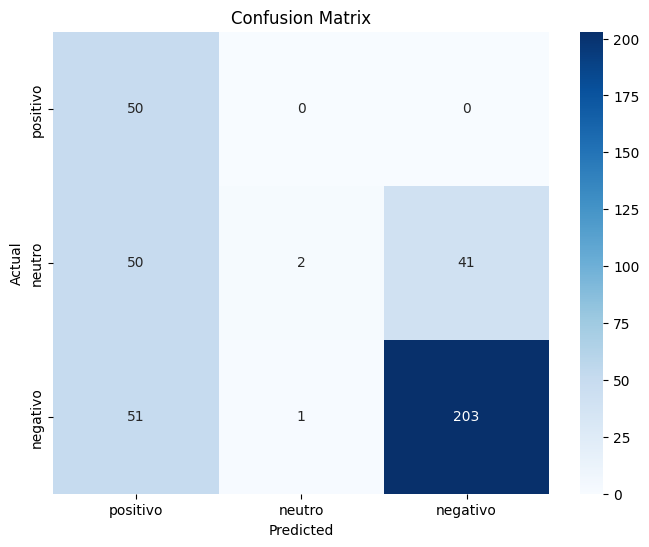

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = trainer_smote.predict(test_dataset)
preds = torch.tensor(predictions.predictions).argmax(dim=1)

id_to_label = {0: 'positivo', 1: 'neutro', 2: 'negativo'}
pred_labels = [id_to_label[id.item()] for id in preds]

test_data['predicted_label'] = pred_labels

# Guardar el archivo con las predicciones
test_data[['Comentario', 'label', 'predicted_label']].to_csv('/content/drive/MyDrive/test_predictions.csv', index=False)

print("Predicciones guardadas en '/content/drive/MyDrive/test_predictions.csv'")

# Evaluar el rendimiento del modelo
print("\nClassification Report:")
report = classification_report(test_data['label'], test_data['predicted_label'], target_names=['positivo', 'neutro', 'negativo'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y=report_df['f1-score'], palette='viridis')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Class')
plt.show()

cm = confusion_matrix(test_data['label'], test_data['predicted_label'])
labels = ['positivo', 'neutro', 'negativo']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Instalar nbconvert si no está instalado
!pip install nbconvert

# Convertir el notebook actual a PDF
!jupyter nbconvert --to pdf resultado.ipynb


[NbConvertApp] WARNING | pattern 'resultado.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    E

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Suponiendo que trainer_smote y test_dataset ya están definidos

# Realizar predicciones en el conjunto de prueba
predictions = trainer_smote.predict(test_dataset)
preds = torch.tensor(predictions.predictions).argmax(dim=1)

# Convertir etiquetas numéricas a etiquetas originales
id_to_label = {0: 'positivo', 1: 'neutro', 2: 'negativo'}
pred_labels = [id_to_label[id.item()] for id in preds]

# Mostrar algunas predicciones
test_data['predicted_label'] = pred_labels
print(test_data[['Comentario', 'label', 'predicted_label']].head())

# Evaluar el rendimiento del modelo
print("\nClassification Report:")
report = classification_report(test_data['label'], test_data['predicted_label'], target_names=['positivo', 'neutro', 'negativo'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y=report_df['f1-score'], palette='viridis')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Class')
plt.show()

cm = confusion_matrix(test_data['label'], test_data['predicted_label'])
labels = ['positivo', 'neutro', 'negativo']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'trainer_smote' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')